<b>Note:</b> Before running, move out of this directory and into "Train data" directory.

### Common problems when training Object Detection and Image Segmentation models:
1. Image dimensions and aspect ratios (especially dealing with extreme values)
2. Labels composition - imbalances, bounding box sizes, aspect ratios (for instance a lot of small objects)
3. Data preparation not suitable for your dataset
4. Modelling approach not aligned with the data

### Load Images and Metadata

In [297]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import glob
from PIL import Image
from PIL.ExifTags import TAGS

In [314]:
folder_path = 'images/*.tiff'

images = []
for img_path in glob.glob(folder_path):
    images.append(mpimg.imread(img_path))

MemoryError: 

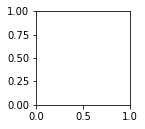

In [333]:
plt.figure(figsize=(20,10))
columns = 5
imgs_ = images[:21]

for i, image in enumerate(imgs_):
    plt.subplot(len(imgs_) // columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

In [334]:
import json
import numpy as np

In [335]:
annotation_file = 'MIDOG.json'
img_metadata = {}

with open(annotation_file) as f:
    data = json.load(f)
    
    for img in data['images']:
        img_metadata[img['id']] = {
            'filename': img['file_name'],
            'width': img['width'],
            'height': img['height']
        }
    
    for annotation in data['annotations']:
        info = {
                'id': annotation['id'],
                'category_id': annotation['category_id'],
                'bbox': annotation['bbox']
            }
        
        try:
            img_metadata[annotation['image_id']]['labels'].append(info)
        except Exception:
            
            img_metadata[annotation['image_id']]['labels'] = []
            img_metadata[annotation['image_id']]['labels'].append(info)

### Check if every image has a bounding box

In [336]:
has_aspect = [1 if 'labels' in img_meta.keys() else 0 for _, img_meta in img_metadata.items()]
print(f'Number of images with bounding box in json: {sum(has_aspect)}')
print(f'Number of images: {len(img_metadata)}')

Number of images with bounding box in json: 150
Number of images: 200


Since, 150 images have bounding box, and there are 200 images in total, 50 images do not have bounding boxes.

### Print aspect ratio of each image

In [337]:
def plot_bar(data):
    data_dict = {}
    
    for value in data:
        try:
            data_dict[value] += 1
        except Exception:
            data_dict[value] = 1
            
    plt.bar(data_dict.values(), data_dict.keys())

Min: 1.31, max: 1.371, mean: 1.3339


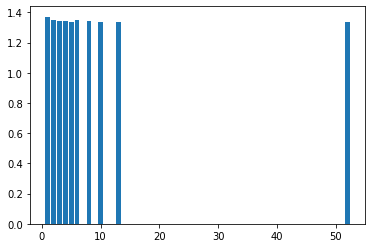

In [338]:
img_aspect_ratios = [round(img_meta['width'] / img_meta['height'], 3) for _, img_meta in img_metadata.items()]
plot_bar(img_aspect_ratios)
print(f"Min: {min(img_aspect_ratios)}, max: {max(img_aspect_ratios)}, mean: {np.mean(np.array(img_aspect_ratios))}")

Min: 1.31, max: 1.371, mean: 1.3339, std: 0.008695976080923871


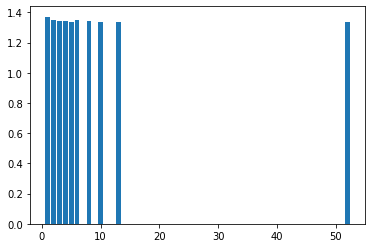

In [339]:
img_areas = [round(img_meta['width'] / img_meta['height'], 3) for _, img_meta in img_metadata.items()]
plot_bar(img_areas)
print(f"Min: {min(img_areas)}, max: {max(img_areas)}, mean: {np.mean(np.array(img_areas))}, std: {np.std(np.array(img_areas))}")

All of the images have similar aspect ratios.

### Print aspect ratio of each bounding box

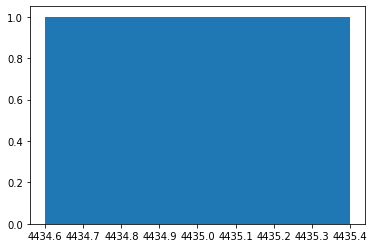

In [340]:
#bbox_aspect_ratios = [round(bbox['width'] / bbox['height'], 3) for _, img_meta in img_metadata.items() for bbox in img_meta['labels']]
#plot_bar(bbox_aspect_ratios)

bbox_aspect_ratios = []
for _, img_meta in img_metadata.items():
    try:
        img_meta['labels']
    except Exception:
        continue
    for label in img_meta['labels']:
        x_min, y_min, x_max, y_max = label['bbox']
        if x_max-x_min > 0 and y_max-y_min > 0:
            #bbox_aspect_ratios.append(round((label['bbox'][0]-label['bbox'][1])/(label['bbox'][2]-label['bbox'][3]), 3)) xywh
            bbox_aspect_ratios.append(round((x_max-x_min)/(y_max-y_min), 3)) # x_min,x_max,y_min,y_max
        else:
            print(f'Something is wrong with: {label}')

plot_bar(bbox_aspect_ratios)

All of the bounding boxes have the same aspect ratio. That means that any resizing or anything will not be needed. Moreover, the aspect ratio of each bounding box is 1.0, which means that all of the bounding boxes are squares (height and width are of the same size). \
After further inspection it was concluded that those 50 ones are from Leica scanner.

### Mitotic VS. Hard Negatives

([<matplotlib.patches.Wedge at 0x24101c55e10>,
 [Text(-0.3789462987978753, 1.0326663074911429, 'Hard negatives: 61.2%'),
  Text(0.37894629879787534, -1.0326663074911429, 'Mitosis: 38.8%')])

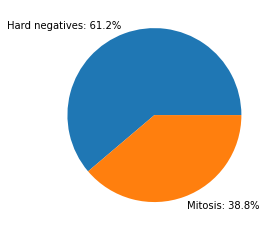

In [341]:
categories = [2-label['category_id'] for _, img_meta in img_metadata.items() if 'labels' in img_meta.keys() for label in img_meta['labels']]
mitosis_num = sum(categories)
total = len(categories)

categories_dict = {0: total-mitosis_num, 1: mitosis_num}
plt.pie(categories_dict.values(), labels=[f'Hard negatives: {round(categories_dict[0] / total*100, 2)}%', f'Mitosis: {round(categories_dict[1] / total*100, 2)}%'])

There are a more hard negatives in the dataset (61.2% vs 38.8%), but the difference is not that big (not big class imbalance).

In [342]:
mitosis_per_img = []
hard_neg_per_img = []
for _, img in img_metadata.items():
        
    mitosis_num = 0
    hard_neg_num = 0
    if 'labels' in img.keys():
        mitosis_num = sum([1 for label in img['labels'] if label['category_id'] == 1])
        hard_neg_num = sum([1 for label in img['labels'] if label['category_id'] == 2])
        
    mitosis_per_img.append(mitosis_num)
    hard_neg_per_img.append(hard_neg_num)

Number of mitosis bounding boxes per image:

<BarContainer object of 200 artists>

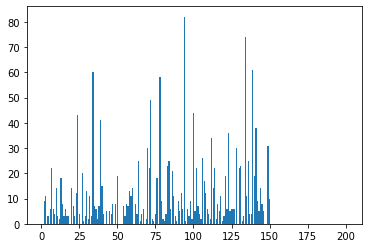

In [343]:
plt.bar(list(range(1, len(mitosis_per_img)+1)), mitosis_per_img)

Number of hard-negative bounding boxes per image:

<BarContainer object of 200 artists>

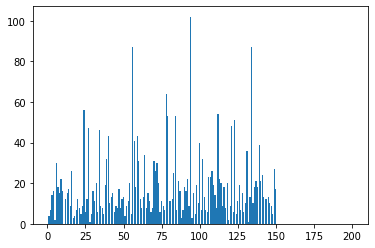

In [344]:
plt.bar(list(range(1, len(hard_neg_per_img)+1)), hard_neg_per_img)

### Descriptive Statistics is in "stats.py"